# Atividade 2 - Sexta Etapa -> RNN

### 1. Importing packs and adictional functions:

In [1]:
import pandas as pd
import numpy as np 
import scipy.io as sio 
import matplotlib.pyplot as plt
 
import tensorflow as tf 
from tensorflow import keras 
    
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.model_selection import train_test_split

In [2]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### 2. Leitura de dados:

    1 - Carregamento dos dados;
    2 - Determinação dos coeficientes alto regressivos;
    3 - Aplicação do pca para redução da dimensionalidade;

In [3]:
mat_contents = sio.loadmat('data3SS2009.mat')
dataset = mat_contents['dataset']
n_samples, n_channels, n_cases = dataset.shape # N, Chno, Nc
y = mat_contents['labels'].reshape(n_cases)

Ch1 = pd.DataFrame(dataset[:,0,:])
Ch2 = pd.DataFrame(dataset[:,1,:])
Ch3 = pd.DataFrame(dataset[:,2,:])
Ch4 = pd.DataFrame(dataset[:,3,:])
Ch5 = pd.DataFrame(dataset[:,4,:])

from statsmodels.tsa.ar_model import AutoReg
Feat = []
lags = 30
for i in range(0,n_cases):
    ar_model_Ch1 = AutoReg(Ch2[i].values, lags = lags).fit()
    ar_model_Ch2 = AutoReg(Ch3[i].values, lags = lags).fit()
    ar_model_Ch3 = AutoReg(Ch4[i].values, lags = lags).fit()
    ar_model_Ch4 = AutoReg(Ch5[i].values, lags = lags).fit()
    ar_models = np.concatenate([ar_model_Ch1.params, ar_model_Ch2.params, ar_model_Ch3.params, ar_model_Ch4.params])
    Feat.append(ar_models)

pca = PCA(n_components = 6)
Feat_reduced = pca.fit_transform(Feat)
Feat_reduced.shape

(850, 6)

In [4]:
Y = mat_contents['labels'].reshape(n_cases)
sc = StandardScaler()
Feat_reduced_scaled = sc.fit_transform(Feat_reduced)
x_train, x_test, y_train, y_test = train_test_split(Feat_reduced_scaled, Y, test_size = 0.3, 
                                                    random_state = 0 )

x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, 
                                                    random_state = 0 )

print('train size: ' f"{x_train.shape}")
print('test size: ' f"{x_test.shape}")
print('val size: ' f"{x_val.shape}")

train size: (595, 6)
test size: (128, 6)
val size: (127, 6)


### 3. Rede neural:

In [63]:
def history_treatment(history) -> pd.DataFrame():
    """
    Função para tratar dados do treinamento
    """
    var = ['loss','accuracy','val_loss','val_accuracy']
    df = pd.DataFrame()
    for i in var:
        df[i] = history.history[i]
    
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
    ax1.set_xlabel('epochs')    
    ax1.set_ylabel('loss')
    ax1.plot(df.loss, label = 'Treino')    
    ax1.plot(df.val_loss, label = 'Validação')    
    ax1.legend()
    ax1.grid()
    
    ax2.set_xlabel('epochs')    
    ax2.set_ylabel('Acurácia')
    ax2.plot(df.accuracy, label = 'Treino')    
    ax2.plot(df.val_accuracy, label = 'Validação')  
    ax2.legend()
    ax2.grid()
 
    return df

In [61]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(20, activation = 'relu')) # hidden layer
model.add(keras.layers.Dense(18, activation = 'softmax')) # output layer (2 classes)

model.compile(loss = "sparse_categorical_crossentropy",  
              optimizer ="adam", metrics = ["accuracy"])

history = model.fit(x_train, y_train, epochs = 250, 
                    validation_data = (x_val,y_val),
                    callbacks = [keras.callbacks.EarlyStopping(patience=10)])


Epoch 1/250
19/19 [==============================] - 1s 16ms/step - loss: 2.8307 - accuracy: 0.0824 - val_loss: 2.7385 - val_accuracy: 0.0866
Epoch 2/250
19/19 [==============================] - 0s 4ms/step - loss: 2.7034 - accuracy: 0.1008 - val_loss: 2.6192 - val_accuracy: 0.1339
Epoch 3/250
19/19 [==============================] - 0s 5ms/step - loss: 2.5839 - accuracy: 0.1513 - val_loss: 2.5055 - val_accuracy: 0.2362
Epoch 4/250
19/19 [==============================] - 0s 4ms/step - loss: 2.4693 - accuracy: 0.2555 - val_loss: 2.3961 - val_accuracy: 0.3386
Epoch 5/250
19/19 [==============================] - 0s 4ms/step - loss: 2.3575 - accuracy: 0.3731 - val_loss: 2.2852 - val_accuracy: 0.4331
Epoch 6/250
19/19 [==============================] - 0s 4ms/step - loss: 2.2453 - accuracy: 0.4235 - val_loss: 2.1767 - val_accuracy: 0.4724
Epoch 7/250
19/19 [==============================] - 0s 4ms/step - loss: 2.1332 - accuracy: 0.4555 - val_loss: 2.0682 - val_accuracy: 0.4882
Epoch 8/250


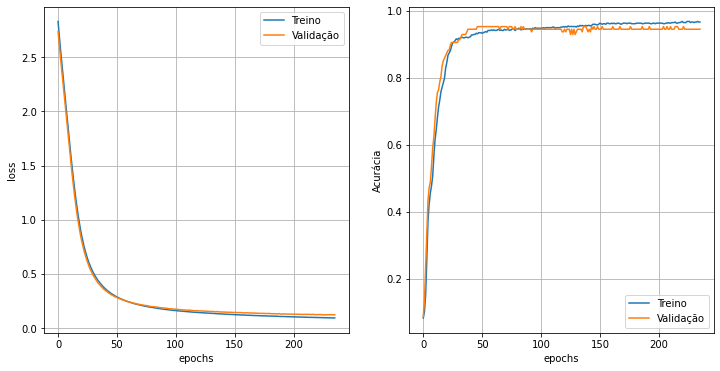

In [64]:
df = history_treatment(history)

#### See tensorBoard:

In [ ]:
# import os 
# root_logdir = os.path.join(os.curdir, "my_logs_new")
# def get_run_logdir():
#     import time 
#     run_id = time.strftime("run_%Y_%m_%d_ - %H_%M_%S")
#     return os.path.join(root_logdir, run_id)
# run_logdir = get_run_logdir()

# tensor_board = keras.callbacks.TensorBoard(run_logdir)

# history = model.fit(x_train, y_train, epochs = 100, 
#                     validation_data = (x_val,y_val),
#                     callbacks = [tensor_board])

In [ ]:
# # Run two times
# %load_ext tensorboard
# %tensorboard --logdir=./my_logs_new --port=6006

#### Metrics:

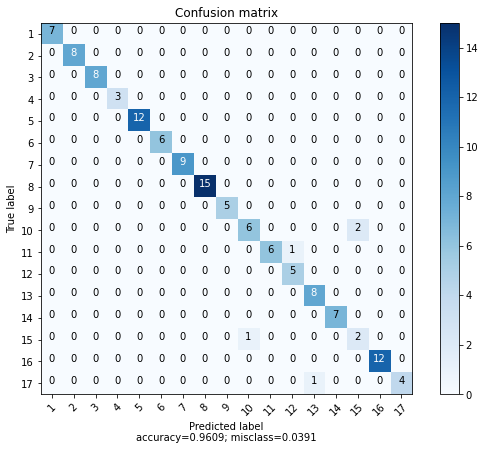

In [79]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,1)
y_pred
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, range(1,18))

### 4.Verify best number of hidden neurons:

In [81]:
history = {}
hidden_neurons = [5, 10, 20, 30, 50]
c = 0
for hn in hidden_neurons:
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(hn, activation = 'relu')) # hidden layer
    model.add(keras.layers.Dense(18, activation = 'softmax')) # output layer (2 classes)

    model.compile(loss = "sparse_categorical_crossentropy",  
                optimizer ="adam", metrics = ["accuracy"])

    history[c] = model.fit(x_train, y_train, epochs = 100, 
                        validation_data = (x_val,y_val),
                        callbacks = [keras.callbacks.EarlyStopping(patience=10)])
    c += 1
    

Epoch 1/100
19/19 [==============================] - 1s 14ms/step - loss: 2.9121 - accuracy: 0.0723 - val_loss: 2.9063 - val_accuracy: 0.0394
Epoch 2/100
19/19 [==============================] - 0s 4ms/step - loss: 2.8643 - accuracy: 0.0739 - val_loss: 2.8642 - val_accuracy: 0.0394
Epoch 3/100
19/19 [==============================] - 0s 4ms/step - loss: 2.8206 - accuracy: 0.0739 - val_loss: 2.8243 - val_accuracy: 0.0394
Epoch 4/100
19/19 [==============================] - 0s 3ms/step - loss: 2.7792 - accuracy: 0.0790 - val_loss: 2.7878 - val_accuracy: 0.0472
Epoch 5/100
19/19 [==============================] - 0s 4ms/step - loss: 2.7407 - accuracy: 0.0908 - val_loss: 2.7520 - val_accuracy: 0.0551
Epoch 6/100
19/19 [==============================] - 0s 4ms/step - loss: 2.7029 - accuracy: 0.1059 - val_loss: 2.7174 - val_accuracy: 0.0866
Epoch 7/100
19/19 [==============================] - 0s 4ms/step - loss: 2.6662 - accuracy: 0.1143 - val_loss: 2.6829 - val_accuracy: 0.0945
Epoch 8/100


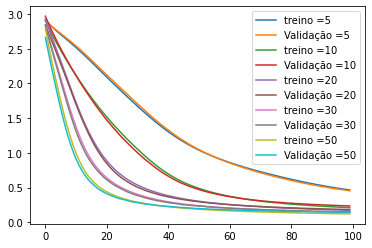

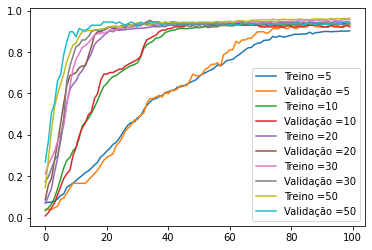

In [101]:
plt.figure(0)
for c in range(0,5):
    h = history[c]
    loss = h.history['loss']
    val = h.history['val_loss']
    plt.plot(loss, label = 'treino =' + str(hidden_neurons[c]))
    plt.plot(val, label = 'Validação =' + str(hidden_neurons[c]))
    plt.legend()

plt.figure(1)
for c in range(0,5):
    h = history[c]
    loss = h.history['accuracy']
    val = h.history['val_accuracy']
    plt.plot(loss, label = 'Treino =' + str(hidden_neurons[c]))
    plt.plot(val, label = 'Validação =' + str(hidden_neurons[c]))
    plt.legend()

Modelo com 10 neurônios na camada escodida se mostra eficiente, pois apresenta uma velocidade interessante de otimização e ganho de acurácia sem muito custo computacional

### 5.Verify best number of hidden neurons:

In [102]:
history = {}
hidden_neurons =  10
activation = ['relu', 'sigmoid', 'softmax','tanh']
c = 0
for ac in activation:
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(10, activation = ac)) # hidden layer
    model.add(keras.layers.Dense(18, activation = 'softmax')) # output layer (2 classes)

    model.compile(loss = "sparse_categorical_crossentropy",  
                optimizer ="adam", metrics = ["accuracy"])

    history[c] = model.fit(x_train, y_train, epochs = 100, 
                        validation_data = (x_val,y_val),
                        callbacks = [keras.callbacks.EarlyStopping(patience=10)])
    c += 1

Epoch 1/100
19/19 [==============================] - 1s 13ms/step - loss: 2.8924 - accuracy: 0.0101 - val_loss: 2.8881 - val_accuracy: 0.0000e+00
Epoch 2/100
19/19 [==============================] - 0s 5ms/step - loss: 2.8061 - accuracy: 0.0185 - val_loss: 2.8038 - val_accuracy: 0.0157
Epoch 3/100
19/19 [==============================] - 0s 4ms/step - loss: 2.7241 - accuracy: 0.0487 - val_loss: 2.7241 - val_accuracy: 0.1102
Epoch 4/100
19/19 [==============================] - 0s 4ms/step - loss: 2.6468 - accuracy: 0.1227 - val_loss: 2.6478 - val_accuracy: 0.1811
Epoch 5/100
19/19 [==============================] - 0s 4ms/step - loss: 2.5709 - accuracy: 0.1697 - val_loss: 2.5732 - val_accuracy: 0.1969
Epoch 6/100
19/19 [==============================] - 0s 4ms/step - loss: 2.4957 - accuracy: 0.1950 - val_loss: 2.4986 - val_accuracy: 0.2047
Epoch 7/100
19/19 [==============================] - 0s 4ms/step - loss: 2.4226 - accuracy: 0.2269 - val_loss: 2.4247 - val_accuracy: 0.2520
Epoch 8/

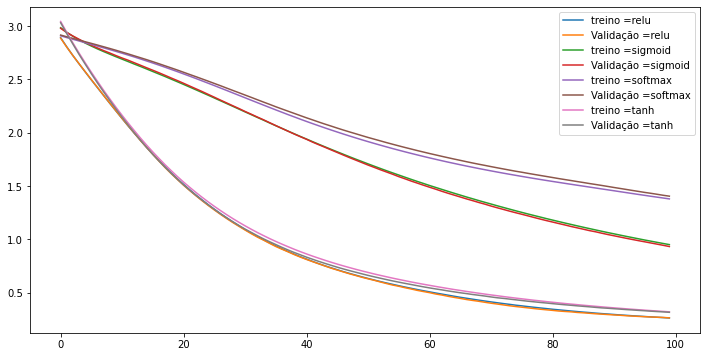

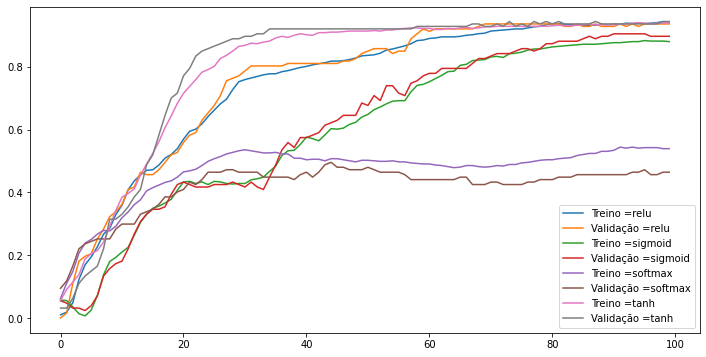

In [105]:
plt.figure(0, figsize=(12,6))
for c in range(0,4):
    h = history[c]
    loss = h.history['loss']
    val = h.history['val_loss']
    plt.plot(loss, label = 'treino =' + str(activation[c]))
    plt.plot(val, label = 'Validação =' + str(activation[c]))
    plt.legend()

plt.figure(1, figsize=(12,6))
for c in range(0,4):
    h = history[c]
    loss = h.history['accuracy']
    val = h.history['val_accuracy']
    plt.plot(loss, label = 'Treino =' + str(activation[c]))
    plt.plot(val, label = 'Validação =' + str(activation[c]))
    plt.legend()

Tanto a Tangente Hiperbolica, quanto a função RELU apresentam respostas interessantes. Devido a similaridade apresentada, qualquer um pode ser empregada.